In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import csv

In [2]:
def get_projection(U, V):
    A, Sig, B = np.linalg.svd(V)
    u_tilda = np.matmul(A[:,0:2].T, U)
    v_tilda = np.matmul(A[:,0:2].T, V)
    return u_tilda, v_tilda

In [3]:
'''
    movies: indices of the movies (movie_id - 1)
'''
def create_visualization(movies_inds, title, V_tilda):
    x_data = [V_tilda[0][i] for i in movies_inds]
    y_data = [V_tilda[1][i] for i in movies_inds]
    group = [movies[i][1] for i in movies_inds]

    # Create dataframe
    df = pd.DataFrame({
    'x': x_data,
    'y': y_data,
    'group': group
    })

    # basic plot
    sns.set_style("whitegrid")
    p1=sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':40})

    # add annotations one by one with a loop
    for line in range(0,df.shape[0]):
         p1.text(df.x[line]+0.04, df.y[line], df.group[line], horizontalalignment='left', 
                 size='small', color='black', weight='semibold')


    # see it
    plt.rcParams["figure.figsize"] = (8, 4)
    plt.title(title)
    plt.show()

In [4]:
def visualization_all3movies(movies, V_tilda):
    x_data = [V_tilda[0][i[0]] for i in movies]
    y_data = [V_tilda[1][i[0]] for i in movies]
    group = [i[1] for i in movies]

    # Create dataframe
    df = pd.DataFrame({
    'x': x_data,
    'y': y_data,
    'group': group
    })
    
    sns.set_style("whitegrid")
    p1 = sns.relplot(x='x', y='y', hue='group', data=df)
    

In [5]:
def visualize(U, V):
    U_tilda, V_tilda = get_projection(U, V)
    
    # Ten movies of your choice:
    rand_movies = random.sample(range(0, 1682), 10)
    title = "Ten Movies of Our Choice"
    create_visualization(rand_movies, title, V_tilda)
    
    # Ten most popular movies:
    popular = [120, 299,   0, 287, 285, 293, 180,  99, 257,  49]
    title = "Ten Most Popular Movies"
    create_visualization(popular, title, V_tilda)
    
    # Ten best movies:
    best = [1535, 1499, 1188, 1200, 1598, 1121,  813, 1652, 1466, 1292]
    title = "Ten Best Movies"
    create_visualization(best, title, V_tilda)
    
    total_three = []
    
    # Ten movies from Romance:
    romance = []
    for i in range(len(movies)):
        if movies[i][16] == '1':
            romance.append(int(movies[i][0])-1)
            total_three.append([int(movies[i][0])-1, "romance"])
    rand_rom = random.sample(romance, 10)
    title = "Ten Romance Movies"
    create_visualization(rand_rom, title, V_tilda)
    
    # Ten movies from Animation:
    animation = []
    for i in range(len(movies)):
        if movies[i][5] == '1':
            animation.append(int(movies[i][0])-1)
            total_three.append([int(movies[i][0])-1, "animation"])

    rand_anim = random.sample(animation, 10)
    title = "Ten Animation Movies"
    create_visualization(rand_anim, title, V_tilda)
    
    # Ten movies from Sci-Fi:
    scifi = []
    for i in range(len(movies)):
        if movies[i][17] == '1':
            scifi.append(int(movies[i][0])-1)
            total_three.append([int(movies[i][0])-1, "sci-fi"])

    rand_sf = random.sample(scifi, 10)
    title = "Ten Scifi Movies"
    create_visualization(rand_sf, title, V_tilda)
    
    visualization_all3movies(total_three, V_tilda)


In [16]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj))     

def grad_V(Vj, Yij, Ui, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - np.dot(U[i-1], V[:,j-1]))**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y))

# Cell 2 from notebook
with open("data/movies.txt","r", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movies = np.array(list(reader))


# Cell 3 from notebook

Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20
reg = 10**-1
eta = 0.03 # learning rate

U,V, e_in = train_model(M, N, k, eta, reg, Y_train)

Epoch 1, E_in (regularized MSE): 0.509488594828
Epoch 2, E_in (regularized MSE): 0.4362818405
Epoch 3, E_in (regularized MSE): 0.407832945453
Epoch 4, E_in (regularized MSE): 0.391887329214
Epoch 5, E_in (regularized MSE): 0.37468194439
Epoch 6, E_in (regularized MSE): 0.36390094599
Epoch 7, E_in (regularized MSE): 0.354649290848
Epoch 8, E_in (regularized MSE): 0.347846059645
Epoch 9, E_in (regularized MSE): 0.338416046493
Epoch 10, E_in (regularized MSE): 0.335658571874
Epoch 11, E_in (regularized MSE): 0.32895146016
Epoch 12, E_in (regularized MSE): 0.324114439141
Epoch 13, E_in (regularized MSE): 0.320294543314
Epoch 14, E_in (regularized MSE): 0.322159601547


(943, 20)
(20, 1682)


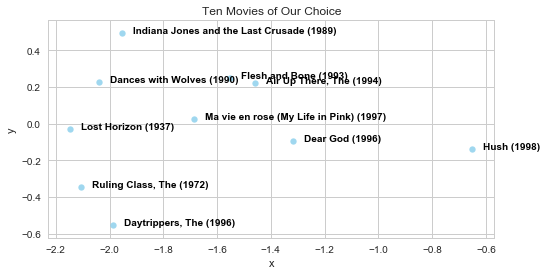

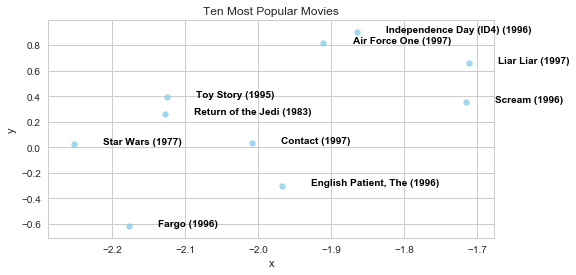

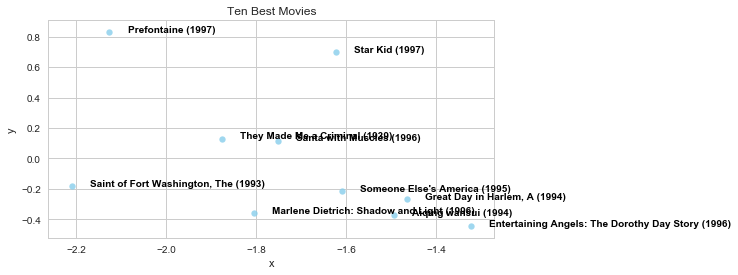

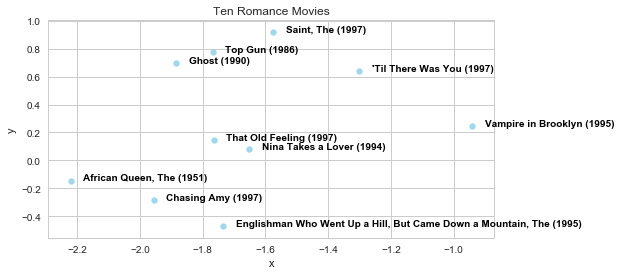

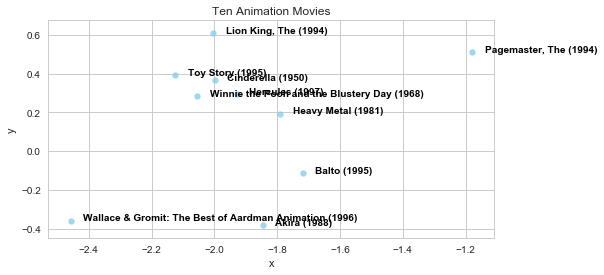

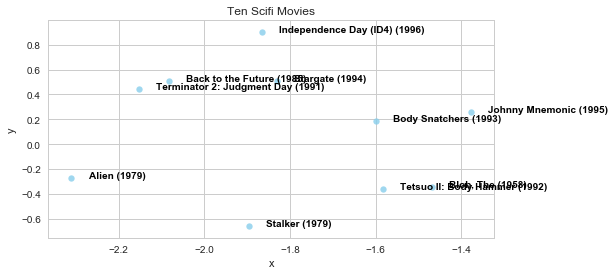

AttributeError: module 'seaborn' has no attribute 'relplot'

In [17]:
print(U.shape)
print(V.shape)
visualize(U.T, V)

In [ ]:
def grad_U(Ui, Yij, Vj, ai, bj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return (1-reg*eta)*Ui + eta * Vj * (Yij - np.dot(Ui,Vj) - ai - bj)     

def grad_V(Vj, Yij, Ui, ai, bj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return (1-reg*eta)*Vj + eta * Ui * (Yij - np.dot(Ui,Vj) - ai - bj)

def get_err(U, V, Y, a, b, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # Compute mean squared error on each data point in Y; include
    # regularization penalty in error calculations.
    # We first compute the total squared squared error
    err = 0.0
    for (i,j,Yij) in Y:
        err += 0.5 *(Yij - np.dot(U[i-1], V[:,j-1]) - a[i-1] - b[j-1])**2
    # Add error penalty due to regularization if regularization
    # parameter is nonzero
    if reg != 0:
        U_frobenius_norm = np.linalg.norm(U, ord='fro')
        V_frobenius_norm = np.linalg.norm(V, ord='fro')
        err += 0.5 * reg * (U_frobenius_norm ** 2)
        err += 0.5 * reg * (V_frobenius_norm ** 2)
    # Return the mean of the regularized error
    return err / float(len(Y))

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    a = np.zeros(M)
    acount = np.zeros(M)
    b = np.zeros(N)
    bcount = np.zeros(N)
    
    for idx in range(Y.shape[0]):
        i, j, Y_ij = Y[idx]
        i -= 1
        j -= 1
        a[i] += Y_ij
        acount[i] += 1
        b[j] = Y_ij
        bcount[j] += 1
        
    for idx in range(M):
        if (acount[idx] != 0):
            a[idx] /= acount[idx]
        
    for idx in range(N):
        if (bcount[idx] != 0):
            b[idx] /= bcount[idx]
            
    # Initialize U, V  
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((K,N)) - 0.5
    size = Y.shape[0]
    delta = None
    indices = np.arange(size)    
    for epoch in range(max_epochs):
        # Run an epoch of SGD
        before_E_in = get_err(U, V, Y, a, b, reg)
        np.random.shuffle(indices)
        for ind in indices:
            (i,j, Yij) = Y[ind]
            # Update U[i], V[j]
            U[i-1] = grad_U(U[i-1], Yij, V[:,j-1], a[i-1], b[j-1], reg, eta)
            V[:,j-1] = grad_V(V[:,j-1], Yij, U[i-1], a[i-1], b[j-1], reg, eta);
        # At end of epoch, print E_in
        E_in = get_err(U, V, Y, a, b, reg)
        print("Epoch %s, E_in (regularized MSE): %s"%(epoch + 1, E_in))

        # Compute change in E_in for first epoch
        if epoch == 0:
            delta = before_E_in - E_in

        # If E_in doesn't decrease by some fraction <eps>
        # of the initial decrease in E_in, stop early            
        elif before_E_in - E_in < eps * delta:
            break
    return (U, V, get_err(U, V, Y, a, b))

# Cell 2 from notebook
with open("data/movies.txt","r", encoding="latin_1") as f:
    reader = csv.reader(f, delimiter="\t")
    
    # Put the contents in a matrix
    movies = np.array(list(reader))


# Cell 3 from notebook

Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies
k = 20
reg = 10**-1
eta = 0.03 # learning rate

U,V, e_in = train_model(M, N, k, eta, reg, Y_train)

Epoch 1, E_in (regularized MSE): 0.522173658713
Epoch 2, E_in (regularized MSE): 0.473113820697
Epoch 3, E_in (regularized MSE): 0.42589702244
Epoch 4, E_in (regularized MSE): 0.398669015479
Epoch 5, E_in (regularized MSE): 0.380748175501
Epoch 6, E_in (regularized MSE): 0.36452919203
Epoch 7, E_in (regularized MSE): 0.351584968627
Epoch 8, E_in (regularized MSE): 0.340340092234
Epoch 9, E_in (regularized MSE): 0.331048785735
Epoch 10, E_in (regularized MSE): 0.322328305822
Epoch 11, E_in (regularized MSE): 0.314835580784
Epoch 12, E_in (regularized MSE): 0.307713726909
Epoch 13, E_in (regularized MSE): 0.30260851152
Epoch 14, E_in (regularized MSE): 0.29757924587
Epoch 15, E_in (regularized MSE): 0.292520019248
Epoch 16, E_in (regularized MSE): 0.289355112729
Epoch 17, E_in (regularized MSE): 0.285875920041
Epoch 18, E_in (regularized MSE): 0.283034999892
Epoch 19, E_in (regularized MSE): 0.280177237321
Epoch 20, E_in (regularized MSE): 0.27820533987
Epoch 21, E_in (regularized MSE): 

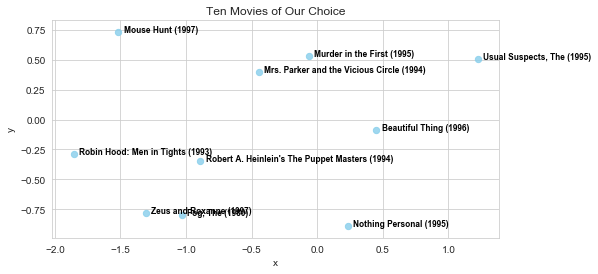

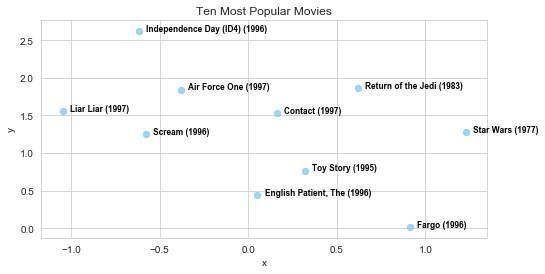

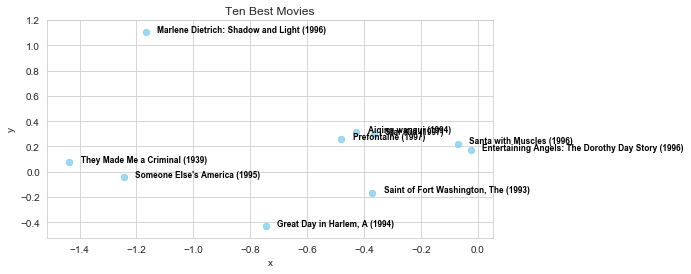

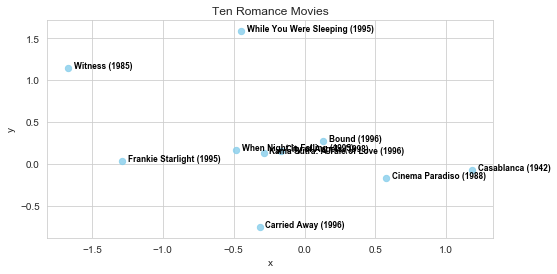

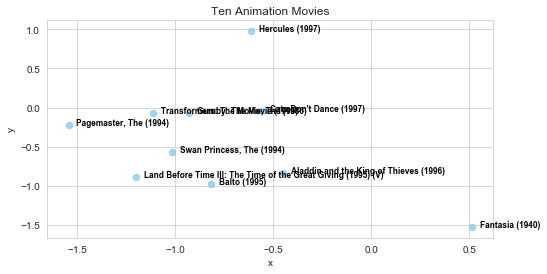

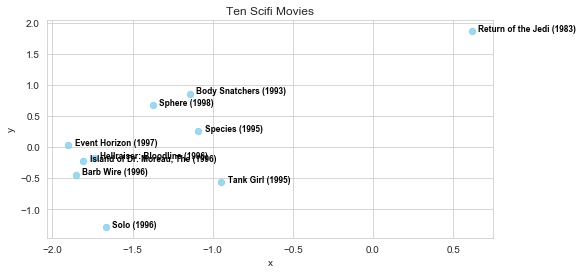

In [104]:
visualize(U.T, V)

In [ ]:
# Try various visualizations of maybe different genres to see
# what meanings the axis have...